### Pulls out the relevant isaura information for visualisation

In [86]:
import sys,os,os.path
sys.path.append("../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'


import os
import sys
import random
import tables as tb
import numpy  as np
import pandas as pd
import scipy.spatial.distance as scidist
import invisible_cities.core.fit_functions  as fitf
from   invisible_cities.core.stat_functions import poisson_sigma
import invisible_cities.reco.dst_functions  as dstf
from   invisible_cities.core.core_functions import shift_to_bin_centers
from invisible_cities.core.testing_utils import assert_hit_equality
from IC.invisible_cities.reco.paolina_functions import voxelize_hits, drop_end_point_voxels, make_track_graphs, get_track_energy
# hack to avoid QhullError
from scipy.spatial.qhull import QhullError
from scipy import spatial
spatial.QhullError = QhullError
from  skimage.morphology import skeletonize_3d

from invisible_cities.evm                  import event_model as evm
from invisible_cities.evm  .event_model    import Cluster, Hit
from invisible_cities.types.ic_types       import xy
from invisible_cities.reco import paolina_functions    as plf


import invisible_cities.io.mcinfo_io as mcio

import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize


import core.functions as func

import imageio

### read in isaura data

In [2]:
path = 'data/'
tracking = pd.read_hdf(path + 'isaura_1_208Tl.h5', 'Tracking/Tracks')
df = pd.read_hdf(path + 'beersheba_1_208Tl.h5', 'DECO/Events')
events = np.unique(df.event.to_numpy())

# also load in MC
dfMC = mcio.load_mchits_df(path + 'isaura_1_208Tl.h5').reset_index()
eventsMC = np.unique(dfMC.event_id.to_numpy())

In [3]:
display(df)
display(dfMC)

display(tracking)
[x for x in tracking.columns.to_list()]

,event,npeak,X,Y,Z,E,Xpeak,Ypeak,time,nsipm,Xrms,Yrms
0,0,0.0,365.875,-194.425,773.807738,0.000003,368.346366,-174.196321,1.373371e+06,0,0,0
1,0,0.0,365.875,-193.425,773.807738,0.000003,368.346366,-174.196321,1.373371e+06,0,0,0
2,0,0.0,366.875,-195.425,773.807738,0.000005,368.346366,-174.196321,1.373371e+06,0,0,0
3,0,0.0,366.875,-194.425,773.807738,0.000006,368.346366,-174.196321,1.373371e+06,0,0,0
4,0,0.0,366.875,-193.425,773.807738,0.000006,368.346366,-174.196321,1.373371e+06,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2865767,648,2.0,118.875,-51.425,724.623506,0.000015,104.680861,-60.381546,6.488070e+08,0,0,0
2865768,648,2.0,119.875,-55.425,724.623506,0.000017,104.680861,-60.381546,6.488070e+08,0,0,0
2865769,648,2.0,119.875,-54.425,724.623506,0.000021,104.680861,-60.381546,6.488070e+08,0,0,0
2865770,648,2.0,119.875,-53.425,724.623506,0.000020,104.680861,-60.381546,6.488070e+08,0,0,0


,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,0,39,0,386.361053,-182.384506,781.322083,2.307219,0.000069,ACTIVE
1,0,39,1,261.051025,-37.941269,863.623169,3.568978,0.000011,ACTIVE
2,0,47,0,214.329819,210.628296,797.141357,4.448271,0.000221,ACTIVE
3,0,62,0,214.330002,210.628357,797.141479,4.448344,0.000023,ACTIVE
4,0,61,0,214.329865,210.628296,797.141418,4.448293,0.000045,ACTIVE
...,...,...,...,...,...,...,...,...,...
117403,324,46,7,131.310883,-206.131348,44.084183,2.968418,0.001434,ACTIVE
117404,324,46,8,131.303696,-206.124832,44.088520,2.968658,0.001053,ACTIVE
117405,324,46,9,131.300247,-206.122803,44.081619,2.968858,0.001334,ACTIVE
117406,324,46,10,131.297440,-206.118759,44.081928,2.969004,0.001585,ACTIVE


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,0.430137,42.219578,36,4200,3,351.875,-207.425,773.807738,...,785.041687,392.553402,-193.996445,778.724004,0.325842,0.274363,0.170068,8.909091,8.938776,8.985429
1,0,1,0.100154,15.492306,7,718,3,253.875,-46.425,857.615981,...,862.386702,265.362191,-36.377118,868.992086,0.100154,0.100154,0.100154,8.909091,8.938776,8.985429
2,0,2,0.019781,15.492306,2,71,3,214.875,205.575,795.273675,...,801.389334,218.590523,211.170733,797.181647,0.019781,0.019781,0.019781,8.909091,8.938776,8.985429
3,2,0,2.199912,499.762729,351,21994,2,125.875,-95.425,505.002684,...,547.067286,291.968568,179.039013,529.855947,0.400130,0.067598,0.000000,8.681818,9.000000,8.834166
4,2,1,0.153573,21.186776,6,847,2,111.875,-121.425,401.142328,...,405.858757,133.016578,-115.886194,406.039125,0.153573,0.153573,0.153573,8.681818,9.000000,8.834166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,646,1,0.185982,20.843466,9,1055,3,206.875,167.575,595.195716,...,612.465506,227.378097,176.879945,602.468363,0.185982,0.185982,0.185982,8.642857,8.400000,8.611381
635,646,2,0.029640,8.400000,2,139,3,319.875,153.575,565.490166,...,566.977897,322.337162,162.249784,566.635683,0.029640,0.029640,0.029640,8.642857,8.400000,8.611381
636,648,0,0.480633,33.379377,19,1617,3,110.875,-229.425,34.134343,...,36.699524,135.346019,-224.123951,50.135720,0.451764,0.450675,0.421806,9.000000,8.666667,8.967392
637,648,1,0.124540,24.046043,9,771,3,59.875,-72.425,665.535675,...,668.477644,69.636085,-68.139340,671.791432,0.124540,0.124540,0.124540,9.000000,8.666667,8.967392


['event',
 'trackID',
 'energy',
 'length',
 'numb_of_voxels',
 'numb_of_hits',
 'numb_of_tracks',
 'x_min',
 'y_min',
 'z_min',
 'r_min',
 'x_max',
 'y_max',
 'z_max',
 'r_max',
 'x_ave',
 'y_ave',
 'z_ave',
 'r_ave',
 'extreme1_x',
 'extreme1_y',
 'extreme1_z',
 'extreme2_x',
 'extreme2_y',
 'extreme2_z',
 'blob1_x',
 'blob1_y',
 'blob1_z',
 'blob2_x',
 'blob2_y',
 'blob2_z',
 'eblob1',
 'eblob2',
 'ovlp_blob_energy',
 'vox_size_x',
 'vox_size_y',
 'vox_size_z']

In [15]:
evt_num = 100

# select an event
evt = events[evt_num]
evtMC = eventsMC[evt_num]
print("Selected event: {} ({} MC)".format(evt, evtMC))

data = df[df.event == evt]
track_data = tracking[tracking.event == evt]
dataMC = dfMC[dfMC.event_id == evtMC]
display(data)

display(dataMC)

display(track_data)

# check energy
print(f'Checking track energy and Beersheba energy:\nBeersheba E: {data.E.sum():.5f} MeV\nTrack E: {track_data.energy.values[0]:.5f}')

Selected event: 200 (100 MC)


,event,npeak,X,Y,Z,E,Xpeak,Ypeak,time,nsipm,Xrms,Yrms
956423,200,0.0,407.875,105.575,375.949022,0.000023,399.48042,134.044006,2.002375e+08,0,0,0
956424,200,0.0,407.875,106.575,375.949022,0.000025,399.48042,134.044006,2.002375e+08,0,0,0
956425,200,0.0,407.875,107.575,375.949022,0.000023,399.48042,134.044006,2.002375e+08,0,0,0
956426,200,0.0,408.875,103.575,375.949022,0.000027,399.48042,134.044006,2.002375e+08,0,0,0
956427,200,0.0,408.875,104.575,375.949022,0.000035,399.48042,134.044006,2.002375e+08,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
971628,200,0.0,377.875,136.575,469.473998,0.000023,399.48042,134.044006,2.002375e+08,0,0,0
971629,200,0.0,377.875,137.575,469.473998,0.000017,399.48042,134.044006,2.002375e+08,0,0,0
971630,200,0.0,378.875,134.575,469.473998,0.000012,399.48042,134.044006,2.002375e+08,0,0,0
971631,200,0.0,378.875,135.575,469.473998,0.000014,399.48042,134.044006,2.002375e+08,0,0,0


,event_id,particle_id,hit_id,x,y,z,time,energy,label
35904,100,22,0,467.537231,174.190033,386.349213,0.928052,0.000006,ACTIVE
35905,100,22,1,467.504730,174.169022,386.395996,0.928262,0.000125,ACTIVE
35906,100,22,2,467.496338,174.163239,386.408875,0.928319,0.000010,ACTIVE
35907,100,22,3,467.459717,174.136185,386.466278,0.928572,0.000130,ACTIVE
35908,100,22,4,467.423950,174.110886,386.523071,0.928820,0.000059,ACTIVE
...,...,...,...,...,...,...,...,...,...
36463,100,37,15,428.810699,160.045212,400.618683,1.102900,0.001416,ACTIVE
36464,100,37,16,428.811462,160.050217,400.611115,1.103118,0.001037,ACTIVE
36465,100,37,17,428.810913,160.056778,400.610504,1.103294,0.001463,ACTIVE
36466,100,37,18,428.811005,160.054337,400.613068,1.103412,0.001721,ACTIVE


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
200,200,0,1.436358,136.99187,192,14473,1,343.875,95.575,375.949022,...,464.064347,451.22825,170.207487,390.979208,0.142478,0.093805,0.0,9.0,8.888889,8.502271


Checking track energy and Beersheba energy:
Beersheba E: 1.43636 MeV
Track E: 1.43636


#### visualise blob position 

In [30]:
print(track_data.blob1_x.values[0])
print(track_data.blob1_y.values[0])
print(track_data.blob1_z.values[0])

361.1407292251659
138.15371969664162
464.0643473838396


In [82]:
def plt_sphere(list_center, list_radius, col = 'g', label = 'template'):
  for c, r in zip(list_center, list_radius):
    
    # draw sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x = r*np.cos(u)*np.sin(v)
    y = r*np.sin(u)*np.sin(v)
    z = r*np.cos(v)

    s1 = ax.plot_surface(x+c[0], y+c[1], z+c[2], color=col, alpha=0.1*np.random.random()+0.9, zorder = 3, label = label)

Text(0.5, 0.98, '3D_deconvolved_plot_200')

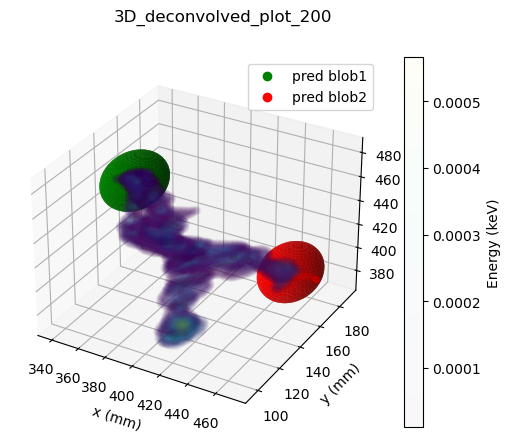

In [90]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')





x = data.X
y = data.Y
z = data.Z
e = data.E

xt = dataMC.x
yt = dataMC.y
zt = dataMC.z
et = dataMC.energy*1000

em = e > 0.00005
##p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
p = ax.scatter(x, y, z, c=e, alpha=0.03, cmap='viridis', zorder=1)
q = ax.scatter(xt, yt, zt, alpha = 0.06, color = 'red', zorder = 0)
cb = fig.colorbar(p, ax=ax)
cb.set_label('Energy (keV)')

plt_sphere([(track_data.blob1_x.values[0], track_data.blob1_y.values[0], track_data.blob1_z.values[0])], [20], col = 'g', label = 'blob1')
plt_sphere([(track_data.blob2_x.values[0], track_data.blob2_y.values[0], track_data.blob2_z.values[0])], [20], col = 'r', label = 'blob2')

fake2Dline1 = mpl.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
fake2Dline2 = mpl.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'o')
ax.legend([fake2Dline1, fake2Dline2], ['pred blob1', 'pred blob2'], numpoints = 1)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

# blob parts

fig.suptitle('3D_deconvolved_plot_' + str(evt))